# Qiskit Support Vector Machine (SVM) Implementation

## *Installation Steps*:
###     Follow the directions in this link to setup an environment for Qiskit:
*Make sure you setup and IBMQ account and save the API token as stated*
1. https://github.com/Qiskit/qiskit-tutorials/blob/master/INSTALL.md

*Install libraries not include in above setup:*
2. ```pip intsall git+https://github.com/Qiskit/qiskit-terra.git```

*Make sure you have pyopencl installed (This may require an OpenCL driver for your computer's specific GPU) https://documen.tician.de/pyopencl/misc.html*
3. ```pip install qcgpu```
4. ```pip install qiskit-qcgpu-provider```

*Lastly, make sure to update the environment again.*
5. ```conda env update -f environment.yml```
6. *Then, activate the environment*.

For Windows: ```activate Qiskitenv```

For Mac/Linux: ```source activate Qiskitenv```




# Quantum SVMs (QSVMs)

Support Vector Machines are a type of machine learning algorithm using in classification problems. They can handle both continuous and categorical data. The idea is to find a hyperplane in the multidemensional feature space the maximizes the distance between all of the class. By using a technique known as a kernel trick, SVMs can separate data which is not linearly separable in its input space. This technique enables SVM to transform input data into higher-dimensional space, where separating linear hyperplane can be found easily with quantum computing. This is because quantum computers are ideal for representing data is higher dimensions. Note that, in contrast to classical kernel machines, the exponential quantum advantage in evaluating inner products allows quantum kernel machines to perform the kernel evaluation directly in the higher dimensional space. In cases when classical sampling algorithms require polynomial time, an exponential speed-up is obtained. At the core of this quantum big data algorithm is a non-sparse matrix exponentiation technique for efficiently performing a matrix inversion of the training data inner-product (kernel) matrix.


```Source: https://quantdare.com/svm-versus-a-monkey/```
![alt text](http://quantdare.com/wp-content/uploads/2016/09/svm_3d.png "SVM Hyperplane Visualization")

## Why use a quantum support vector machine? 
It can be implemented with *O(log NM)* run time in both training and classification stages. The ability of quantum computers to manipulate highdimensional vectors affords a natural quantum algorithm for polynomial kernel machines. These are run in the black box, *oracle*. The quantum machine learning performance is relative to these oracles and can be considered a lower bound for the true complexity

## How it works:
For the preparation, first call the training data oracles with the state:

```1/root(M) * summation from i = 1 to M |i>```

This prepares in quantum parallel the state
```|χ> = 1/root(Nχ) * summation from i = 1 to M |xi||i>xi>```, with ```Nχ = summation from i = 1 to M of |xi|^2```, in
O(log NM) run time. If we discard the training set register, we obtain the desired kernel matrix as a quantum density matrix. This matrix is then a format usable by the quantum computer. The solution to the least squares is then found from a system of linear equations that are easily solved through quantum processing. This trains the model. All of this is done inside of the oracle.



Quantum machine learning can take two forms: where classical machine learning algorithms are transformed into their quantum counterparts; to be implemented on a quantum information processor, or taking some of the computationally expensive classical machine learning sub-routines and implementing them on the quantum computer.


### Testing inputs
Now the quantum matix is put in an inversion which essentially performs a kernel matrix principal component analysis (PCA), giving a time/error analysis of the quantum algorithm.

###### Source Provide by: https://arxiv.org/pdf/1307.0471.pdf

# Using QSVMs with Qiksit

## Step 1: Import the necessary libraries

In [1]:
# For need math with kernel matrices
import numpy as np
import scipy
from scipy.linalg import expm

# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sklearn for datasets, splitting data, scling, PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Qiskit stuff
from qiskit_aqua.utils import split_dataset_to_data_and_labels
from qiskit_aqua.input import SVMInput
from qiskit_aqua import run_algorithm
from qiskit_qcgpu_provider import QCGPUProvider

## Step 2: Create oracle (black box) functions
This is where data will be split into training and test samples and then the model is trained. This is where the quantum computing *magic* happens. There is one oracle for each implemented data set.

In [2]:
def breast_cancer(training_size, test_size, n, PLOT_DATA):
    
    # Label classes
    class_labels = [r'Benign', r'Malignant']
    
    # Get data set from sklearn
    data, target = datasets.load_breast_cancer(True)
    
    # Split dataset 70% train, 30% test
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size=0.3, random_state=12)

    # Standarize around 0 with unit variance
    std_scale = StandardScaler().fit(Xtrain)
    Xtrain = std_scale.transform(Xtrain)
    Xtest = std_scale.transform(Xtest)

    # Reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(Xtrain)
    Xtrain = pca.transform(Xtrain)
    Xtest = pca.transform(Xtest)

    # Scale to the range (-1,+1)
    XData = np.append(Xtrain, Xtest, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(XData)
    sample_train = minmax_scale.transform(Xtrain)
    sample_test = minmax_scale.transform(Xtest)

    # Pick training size number of samples from each distro
    training_input = {key: (Xtrain[Ytrain == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (Xtrain[Ytrain == k, :])[training_size:(training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, len(class_labels)):
            plt.scatter(Xtrain[Ytrain == k, 0][:training_size],
                        Xtrain[Ytrain == k, 1][:training_size])

        plt.title("PCA : {}, Breast cancer dataset".format(n))
        plt.show()

    return Xtrain, training_input, test_input, class_labels

In [3]:
def digits(training_size, test_size, n, PLOT_DATA):
    
    # Label Classes
    class_labels = [r'0', r'1', r'2', r'3', r'4', r'5', r'6', r'7', r'8', r'9']
    
    # Load Dataset from sklearn
    data = datasets.load_digits()
    
    #Split data set 30% testing, 70% training
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(data.data, data.target, test_size=0.3, random_state=22)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(Xtrain)
    Xtrain = std_scale.transform(Xtrain)
    Xtest = std_scale.transform(Xtest)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(Xtrain)
    Xtrain = pca.transform(Xtrain)
    Xtest = pca.transform(Xtest)

    # Scale to the range (-1,+1)
    XData = np.append(Xtrain, Xtest, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(XData)
    Xtrain = minmax_scale.transform(Xtrain)
    Xtest = minmax_scale.transform(Xtest)

    # For results in QSVM
    training_input = {key: (Xtrain[Ytrain == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (Xtrain[Ytrain == k, :])[training_size:(training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, len(class_labels)):
            plt.scatter(Xtrain[Ytrain == k, 0][:training_size],
                        Xtrain[Ytrain == k, 1][:training_size])

        plt.title("PCA : {}, Digits Data Set".format(n))
        plt.show()

    return Xtrain, training_input, test_input, class_labels

In [4]:
def iris(training_size, test_size, n, PLOT_DATA):
    
    # Label Classes
    class_labels = [r'Setosa', r'Versicolour', r'Virginica']
    
    # Get dataset from sklearn
    data, target = datasets.load_iris(True)
    
    # Split dataset 70% train, 30% testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size=1, random_state=42)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(Xtrain)
    Xtrain = std_scale.transform(Xtrain)
    Xtest = std_scale.transform(Xtest)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(Xtrain)
    Xtrain = pca.transform(Xtrain)
    Xtest = pca.transform(Xtest)

    # Scale to the range (-1,+1)
    XData = np.append(Xtrain, Xtest, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(XData)
    Xtrain = minmax_scale.transform(Xtrain)
    Xtest = minmax_scale.transform(Xtest)

    # For results later
    training_input = {key: (Xtrain[Ytrain == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (Xtrain[Ytrain == k, :])[training_size:(training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, len(class_labels)):
            plt.scatter(Xtrain[Ytrain == k, 0][:training_size],
                        Xtrain[Ytrain == k, 1][:training_size])

        plt.title("PCA : {}, Iris dataset".format(n))
        plt.show()

    return Xtrain, training_input, test_input, class_labels

In [5]:
def wine(training_size, test_size, n, PLOT_DATA):
    
    # Label Classes
    class_labels = [r'A', r'B', r'C']

    # Load Dataset from sklearn
    data, target = datasets.load_wine(True)
    
    # Split data set 70% training, 30% testing
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, target, test_size=test_size, random_state=7)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(Xtrain)
    Xtrain = std_scale.transform(Xtrain)
    Xtest = std_scale.transform(Xtest)
    
    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(Xtrain)
    Xtrain = pca.transform(Xtrain)
    Xtest = pca.transform(Xtest)

    # Scale data to between (-1,1)
    XData = np.append(Xtrain, Xtest, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(XData)
    Xtrain = minmax_scale.transform(Xtrain)
    Xtest = minmax_scale.transform(Xtest)
    
    
    # Pick training data for results later
    training_input = {key: (Xtrain[Ytrain == k, :])[:training_size] for k, key in enumerate(class_labels)}
    
    # Rest of data goes to test for results later
    test_input = {key: (Xtrain[Ytrain == k, :])[training_size:(training_size+test_size)] for k, key in enumerate(class_labels)}
    
    # For plotting data
    if PLOT_DATA:
        for k in range(0, len(class_labels)):
            plt.scatter(Xtrain[Ytrain == k, 0][:training_size],
                        Xtrain[Ytrain == k, 1][:training_size])

        plt.title("PCA : {}, Wine dataset".format(n))
        plt.show()

    return Xtrain, training_input, test_input, class_labels

## Step 3: Run algorithms and Display Results
### Components:
#### Dictionary of dictionary with these parameters:
```If using algorithm 'QSVM.Kernel', a backend and feature_map must be provided. If using an RBF classical kernel with algorithm 'SVM', the backend and feature_map are not required```

    'problem'              : {'name': 'svm_classification'},
    'algorithm'            : {'name': 'QSVM.Kernel'},
    'backend'              : {'name': 'qasm_simulator', 'shots': 1024},
    'feature_map'          : {'name': 'SecondOrderExpansion',
                             'depth': 2, 'entanglement': 'linear'}
    'multiclass_extension' : {'name': 'OneAgainstRest'}
        
### Multiclass extentions:
Information Below from documentation:
https://qiskit.org/documentation/aqua/multiclass_extensions.html
##### One Against Rest :  'OneAgainstRest'
For a n-class problem, the one-against-rest method constructs SVM classifiers, with the n-th classifier separating class from all the remaining classes. When the classifiers are combined to make the final decision, the classifier that generates the highest value from its decision function is selected as the winner and the corresponding class label is returned.
##### All Pairs :  'AllPairs'
In the all-pairs reduction, one trains k(k-1)/2 binary classifiers for a k-way multiclass problem; each receives the samples of a pair of classes from the original training set, and must learn to distinguish these two classes. At prediction time, a weighted voting scheme is used: all k(k-1)/2 classifiers are applied to an unseen sample, and each class gets assigned the sum of all the scores obtained by the various classifiers. The combined classifier returns as a result the class getting the highest value.
##### Error Correcting Code :  'Error Correcting Code'
Error Correcting Code (ECC) is an ensemble method designed for the multiclass classification problem. As for the other methods, the task is to decide one label from k > 2 possible choices.

<table border="1" class="docutils">
<colgroup>
<col width="8%" />
<col width="15%" />
<col width="15%" />
<col width="15%" />
<col width="15%" />
<col width="15%" />
<col width="15%" />
</colgroup>
<tbody valign="top">
<tr class="row-odd"><td rowspan="2">Class</td>
<td colspan="6">Code Word</td>
</tr>
<tr class="row-even"><td><span class="math notranslate nohighlight">\(f_0\)</span></td>
<td><span class="math notranslate nohighlight">\(f_1\)</span></td>
<td><span class="math notranslate nohighlight">\(f_2\)</span></td>
<td><span class="math notranslate nohighlight">\(f_3\)</span></td>
<td><span class="math notranslate nohighlight">\(f_4\)</span></td>
<td><span class="math notranslate nohighlight">\(f_5\)</span></td>
</tr>
<tr class="row-odd"><td>1</td>
<td>0</td>
<td>1</td>
<td>0</td>
<td>1</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="row-even"><td>2</td>
<td>1</td>
<td>0</td>
<td>0</td>
<td>1</td>
<td>0</td>
<td>0</td>
</tr>
<tr class="row-odd"><td>3</td>
<td>1</td>
<td>1</td>
<td>1</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
</tbody>
</table>

The table above shows a 6-bit ECC for a 3-class problem. Each class is assigned a unique binary string of length 6. The string is also called a codeword. For example, class 2 has codeword `100100`. During training, one binary classifier is learned for each column. For example, for the first column, ECC builds a binary classifier to separate {2,3} from {1}. Thus, 6 binary classifiers are trained in this way. To classify a new data point x, all 6 binary classifiers are evaluated to obtain a 6-bit string. Finally, we choose the class whose bitstring is closest to x’s output string as the predicted label. Aqua’s implementaion of ECC uses the Euclidean distance.

*NOTE:*
`Provide the dictionary extention 'code_size', a positive integer parameter representing the length of the bitstrings.`

### Feature Maps
Information below from documentation:
https://qiskit.org/documentation/aqua/feature_maps.html

*NOTE:*
`depth: This parameter takes an int value greater than 0. The default value is 2.`

##### First Order Expansion :  'FirstOrderExpansion'
The First Order Expansion feature map transform data x E R according to the following equation, and then concatenates the same circuit d times, where d is the depth of the circuit.

##### Second Order Expansion :  'SecondOrderExpansion'
The Second Order Expansion feature map transform data x E Raccording to the following equation, and then duplicate the same circuit with depth d times, where d is the depth of the circuit.

*NOTE: must provide entaglement map*

```Only two entaglement values are supported: "full" and "linear", corresponding to the full (or all-to-all) and linear (or next-neighbor coupling) entangler maps, respectively. With full entanglement, each qubit i is entangled with all the others; with linear entanglement, qubit is entangled with qubit i+1, for all i E {0, 1, ..., q-2}, where q is the total number of qubits.```

##### Pauli Z Expansion & Pauli Expansion not discussed, but information in link above

### Breast Cancer Data Set

Breast Cancer Data Set: 30 features : Number of instances = 569 (in 2 classes)
How many qubits would you like to use?	2
Would you like to also run the QSVM?	yes


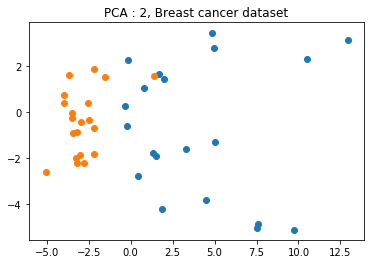

{'Benign': 0, 'Malignant': 1}



Didn't run multiclass extention provided because 2 of fewer classes.


Dataset has just two classes. Supplied multiclass extension will be ignored
Dataset has just two classes. Supplied multiclass extension will be ignored
Dataset has just two classes. Supplied multiclass extension will be ignored
Dataset has just two classes. Supplied multiclass extension will be ignored
Dataset has just two classes. Supplied multiclass extension will be ignored

Wall time: 1.44 s
>>>>> Multiclass Extension QSVM: 'OneAgainstRest' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted class: ['Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign']
accuracy:        0.5


Wall time: 46.2 ms
>>>>> Multiclass Extension RBF SVM: 'OneAgainstRest' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:      [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predicted class: ['Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign']
accuracy:        0.5





Didn't run multiclass extention provided because 2 of fewer classes.
Wall time: 44.8 ms
>>>>> Multiclass E


Dataset has just two classes. Supplied multiclass extension will be ignored


Wall time: 49.3 ms
>>>>> Multiclass Extension QSVM: 'ErrorCorrectingCode' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
predicted class: ['Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant']
accuracy:        1.0


Wall time: 56.1 ms
>>>>> Multiclass Extension RBF SVM: 'ErrorCorrectingCode' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:      [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
predicted class: ['Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant']
accuracy:        1.0




In [6]:
# Number of qubits that will be used
print("Breast Cancer Data Set: 30 features : Number of instances = 569 (in 2 classes)")
feature_dim = int(input("How many qubits would you like to use?\t"))
quantum = input("Would you like to also run the QSVM?\t")
if(quantum == "yes"):
    quantum = True
else:
    quantum = False
    
# Call training function
sample_Total, training_input, test_input, class_labels = breast_cancer(training_size=20,
                                                                       test_size=10, n=feature_dim, PLOT_DATA=True)

# Split data into test and train to be sent to QSVM algorithm
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

#Print labels below Graph (if plotted)
print(class_to_label)

# Choose a backend, Not using IBMQ for testing purposes
backend = QCGPUProvider().get_backend('qasm_simulator')

# Get input ready for SVM
algo_input = SVMInput(training_input, test_input, datapoints[0])

# Filled out parameters are discussed above
if(len(test_input) >2):
    parametersEXT = {
        'problem': {'name': 'svm_classification'},
        'algorithm': {'name': 'QSVM.Kernel'},
        'backend':{'name': 'qasm_simulator', 'shots': 1024},
        'feature_map':{'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'},
        'multiclass_extension':{'name': 'OneAgainstRest'}
    }
else:
    parametersEXT = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'SVM'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

parameters = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'SVM'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

# Multiclass ententions to loop through (Explained above)
extensions = [
   {'name': 'OneAgainstRest'},
   {'name': 'AllPairs'}, 
   {'name': 'ErrorCorrectingCode', 'code_size': 2}
]

# Loop through Multiclass extentions and print the results.
for extension in extensions:
    if(quantum):
            print('\n')
            parametersEXT['multiclass_extension'] = extension
            if(len(parametersEXT) > 3):
                %time result = run_algorithm(parametersEXT, algo_input, backend)
                print(">>>>> Multiclass Extension QSVM: '{}' <<<<<\n".format(extension['name']))
                print("ground truth:    {}".format(datapoints[1]))
                print("prediction:      {}".format(result['predicted_labels']))
                print("predicted class: {}".format(result['predicted_classes']))
                print("accuracy:        {}".format(result['testing_accuracy']))
            else:
                print("\nDidn't run multiclass extention provided because 2 of fewer classes.")
                %time result = run_algorithm(parametersEXT, algo_input, backend)
                print(">>>>> Multiclass Extension QSVM: '{}' <<<<<\n".format(extension['name']))
                print("ground truth:    {}".format(datapoints[1]))
                print("prediction:      {}".format(result['predicted_labels']))
                print("predicted class: {}".format(result['predicted_classes']))
                print("accuracy:        {}".format(result['testing_accuracy']))
    
    print('\n')
    parameters['multiclass_extension'] = extension
    %time result = run_algorithm(parameters, algo_input)
    print(">>>>> Multiclass Extension RBF SVM: '{}' <<<<<\n".format(extension['name']))
    print("ground truth:    {}".format(datapoints[1]))
    print("prediction:      {}".format(result['predicted_labels']))
    print("predicted class: {}".format(result['predicted_classes']))
    print("accuracy:        {}".format(result['testing_accuracy']))
    print('\n')
    #for k,v in result.items():
        #print("'{}' : {}".format(k, v))

### Digits Data Set:

Digits Data Set: 16 features : Number of instances = 1797 (~180 in 10 classes)
How many qubits would you like to use?	2
Would you like to also run the QSVM?	no


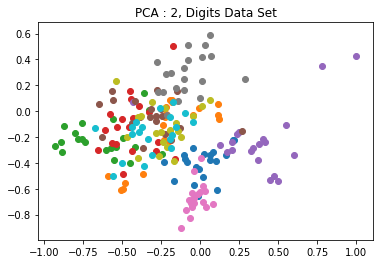

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


Wall time: 58.6 ms
>>>>> Multiclass Extension RBF SVM: 'OneAgainstRest' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
prediction:      [6 6 6 6 6 6 0 4 4 6 8 1 1 1 6 0 8 6 7 4 2 2 2 2 2 2 2 2 2 2 7 2 2 2 7 3 2
 2 9 2 4 4 4 4 4 4 4 4 4 4 8 5 2 5 1 2 7 2 5 8 6 4 6 6 6 6 6 6 6 6 7 7 7 7
 1 7 7 7 7 7 1 5 5 8 7 7 9 7 7 7 9 2 5 1 8 5 2 2 9 2]
predicted class: ['6', '6', '6', '6', '6', '6', '0', '4', '4', '6', '8', '1', '1', '1', '6', '0', '8', '6', '7', '4', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '7', '2', '2', '2', '7', '3', '2', '2', '9', '2', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '8', '5', '2', '5', '1', '2', '7', '2', '5', '8', '6', '4', '6', '6', '6', '6', '6', '6', '6', '6', '7', '7', '7', '7', '1', '7'

In [7]:
# Number of qubits that will be used
print("Digits Data Set: 16 features : Number of instances = 1797 (~180 in 10 classes)")
feature_dim = int(input("How many qubits would you like to use?\t"))
quantum = input("Would you like to also run the QSVM?\t")
if(quantum == "yes"):
    quantum = True
else:
    quantum = False
# Call training function
sample_Total, training_input, test_input, class_labels = digits(training_size=20, test_size=10,
                                                                n=feature_dim, PLOT_DATA=True)

# Split data into test and train to be sent to QSVM algorithm
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

#Print labels below Graph (if plotted)
print(class_to_label)

# Choose a backend, Not using IBMQ for testing purposes
backend = QCGPUProvider().get_backend('qasm_simulator')

# Get input ready for SVM
algo_input = SVMInput(training_input, test_input, datapoints[0])

# Filled out parameters are discussed above
parametersEXT = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'QSVM.Kernel'},
    'backend':{'name': 'qasm_simulator', 'shots': 1024},
    'feature_map':{'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

parameters = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'SVM'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

# Multiclass ententions to loop through (Explained above)
extensions = [
   {'name': 'OneAgainstRest'},
   {'name': 'AllPairs'}, 
   {'name': 'ErrorCorrectingCode', 'code_size': 9}
]

# Loop through Multiclass extentions and print the results.
for extension in extensions:
    if(quantum):
        if(len(test_input) >2):
            print('\n')
            parametersEXT['multiclass_extension'] = extension
            %time result = run_algorithm(parametersEXT, algo_input, backend)
            print(">>>>> Multiclass Extension QSVM: '{}' <<<<<\n".format(extension['name']))
            print("ground truth:    {}".format(datapoints[1]))
            print("prediction:      {}".format(result['predicted_labels']))
            print("predicted class: {}".format(result['predicted_classes']))
            print("accuracy:        {}".format(result['testing_accuracy']))
        else:
            print("Didn't run multiclass extention provided because 2 of fewer classes.")
    
    print('\n')
    parameters['multiclass_extension'] = extension
    %time result = run_algorithm(parameters, algo_input)
    print(">>>>> Multiclass Extension RBF SVM: '{}' <<<<<\n".format(extension['name']))
    print("ground truth:    {}".format(datapoints[1]))
    print("prediction:      {}".format(result['predicted_labels']))
    print("predicted class: {}".format(result['predicted_classes']))
    print("accuracy:        {}".format(result['testing_accuracy']))
    print('\n')
    #for k,v in result.items():
        #print("'{}' : {}".format(k, v))

### Iris Data Set:

Iris Data Set: 4 features : Number of Instance = 150 (50 in each of three classes)
How many qubits would you like to use?	2
Would you like to also run the QSVM?	no


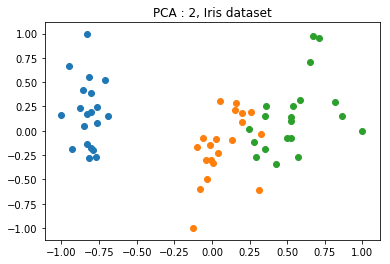

{'Setosa': 0, 'Versicolour': 1, 'Virginica': 2}


Wall time: 41.6 ms
>>>>> Multiclass Extension RBF SVM: 'OneAgainstRest' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
prediction:      [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 1 2 1]
predicted class: ['Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Versicolour', 'Versicolour', 'Versicolour', 'Versicolour', 'Versicolour', 'Versicolour', 'Virginica', 'Versicolour', 'Versicolour', 'Versicolour', 'Versicolour', 'Versicolour', 'Versicolour', 'Virginica', 'Virginica', 'Virginica', 'Virginica', 'Versicolour', 'Virginica', 'Versicolour']
accuracy:        0.8




Wall time: 35.8 ms
>>>>> Multiclass Extension RBF SVM: 'AllPairs' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
prediction:      [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 1 1 1 2 1 2 2 2 2 2 2 2 2]
predicted class: ['Setosa', 'Setosa', 'Setosa', 'Se

In [8]:
# Number of qubits that will be used
print("Iris Data Set: 4 features : Number of Instance = 150 (50 in each of three classes)")
feature_dim = int(input("How many qubits would you like to use?\t"))
quantum = input("Would you like to also run the QSVM?\t")
if(quantum == "yes"):
    quantum = True
else:
    quantum = False
# Call training function
sample_Total, training_input, test_input, class_labels = iris(training_size=20, test_size=10,
                                                              n=feature_dim, PLOT_DATA=True)

# Split data into test and train to be sent to QSVM algorithm
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

#Print labels below Graph (if plotted)
print(class_to_label)

# Choose a backend, Not using IBMQ for testing purposes
backend = QCGPUProvider().get_backend('qasm_simulator')

# Get input ready for SVM
algo_input = SVMInput(training_input, test_input, datapoints[0])

# Filled out parameters are discussed above
parametersEXT = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'QSVM.Kernel'},
    'backend':{'name': 'qasm_simulator', 'shots': 1024},
    'feature_map':{'name': 'SecondOrderExpansion', 'depth': 3, 'entanglement': 'linear'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

parameters = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'SVM'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

# Multiclass ententions to loop through (Explained above)
extensions = [
   {'name': 'OneAgainstRest'},
   {'name': 'AllPairs'}, 
   {'name': 'ErrorCorrectingCode', 'code_size': 4}
]

# Loop through Multiclass extentions and print the results.
for extension in extensions:
    if(quantum):
        if(len(test_input) >2):
            print('\n')
            parametersEXT['multiclass_extension'] = extension
            %time result = run_algorithm(parametersEXT, algo_input, backend)
            print(">>>>> Multiclass Extension QSVM: '{}' <<<<<\n".format(extension['name']))
            print("ground truth:    {}".format(datapoints[1]))
            print("prediction:      {}".format(result['predicted_labels']))
            print("predicted class: {}".format(result['predicted_classes']))
            print("accuracy:        {}".format(result['testing_accuracy']))
        else:
            print("Didn't run multiclass extention provided because 2 of fewer classes.")
    
    print('\n')
    parameters['multiclass_extension'] = extension
    %time result = run_algorithm(parameters, algo_input)
    print(">>>>> Multiclass Extension RBF SVM: '{}' <<<<<\n".format(extension['name']))
    print("ground truth:    {}".format(datapoints[1]))
    print("prediction:      {}".format(result['predicted_labels']))
    print("predicted class: {}".format(result['predicted_classes']))
    print("accuracy:        {}".format(result['testing_accuracy']))
    print('\n')
    #for k,v in result.items():
        #print("'{}' : {}".format(k, v))

### Wine Data Set:

Wine Data Set: 13 Features : Number of instances = 178 (~50 in each of three classes)
How many qubits would you like to use?	2
Would you like to also run the QSVM?	no


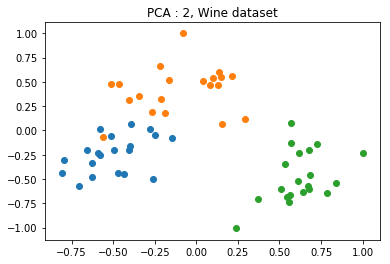

{'A': 0, 'B': 1, 'C': 2}


Wall time: 59.8 ms
>>>>> Multiclass Extension RBF SVM: 'OneAgainstRest' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
prediction:      [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
predicted class: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
accuracy:        1.0




Wall time: 38.9 ms
>>>>> Multiclass Extension RBF SVM: 'AllPairs' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
prediction:      [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
predicted class: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
accuracy:        1.0




Wall time: 48.7 ms
>>>>> Multiclass Extension RBF SVM: 'ErrorCorrectingCode' <<<<<

ground truth:    [0 0 0 0 0 0 0 0 0

In [9]:
# Number of qubits that will be used
print("Wine Data Set: 13 Features : Number of instances = 178 (~50 in each of three classes)")
feature_dim = int(input("How many qubits would you like to use?\t"))
quantum = input("Would you like to also run the QSVM?\t")
if(quantum == "yes"):
    quantum = True
else:
    quantum = False
# Call training function
sample_Total, training_input, test_input, class_labels = wine(training_size=20, test_size=10,
                                                              n=feature_dim, PLOT_DATA=True)

# Split data into test and train to be sent to QSVM algorithm
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

#Print labels below Graph (if plotted)
print(class_to_label)

# Choose a backend, Not using IBMQ for testing purposes
backend = QCGPUProvider().get_backend('qasm_simulator')

# Get input ready for SVM
algo_input = SVMInput(training_input, test_input, datapoints[0])

# Filled out parameters are discussed above
parametersEXT = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'QSVM.Kernel'},
    'backend':{'name': 'qasm_simulator', 'shots': 1024},
    'feature_map':{'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

parameters = {
    'problem': {'name': 'svm_classification'},
    'algorithm': {'name': 'SVM'},
    'multiclass_extension':{'name': 'OneAgainstRest'}
}

# Multiclass ententions to loop through (Explained above)
extensions = [
   {'name': 'OneAgainstRest'},
   {'name': 'AllPairs'}, 
   {'name': 'ErrorCorrectingCode', 'code_size': 3}
]

# Loop through Multiclass extentions and print the results.
for extension in extensions:
    if(quantum):
        if(len(test_input) >2):
            print('\n')
            parametersEXT['multiclass_extension'] = extension
            %time result = run_algorithm(parametersEXT, algo_input, backend)
            print(">>>>> Multiclass Extension QSVM: '{}' <<<<<\n".format(extension['name']))
            print("ground truth:    {}".format(datapoints[1]))
            print("prediction:      {}".format(result['predicted_labels']))
            print("predicted class: {}".format(result['predicted_classes']))
            print("accuracy:        {}".format(result['testing_accuracy']))
        else:
            print("Didn't run multiclass extention provided because 2 of fewer classes.")
    
    print('\n')
    parameters['multiclass_extension'] = extension
    %time result = run_algorithm(parameters, algo_input)
    print(">>>>> Multiclass Extension RBF SVM: '{}' <<<<<\n".format(extension['name']))
    print("ground truth:    {}".format(datapoints[1]))
    print("prediction:      {}".format(result['predicted_labels']))
    print("predicted class: {}".format(result['predicted_classes']))
    print("accuracy:        {}".format(result['testing_accuracy']))
    print('\n')
    #for k,v in result.items():
        #print("'{}' : {}".format(k, v))